<a href="https://colab.research.google.com/github/manthanawgan/MLops/blob/main/Duration_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error


In [ ]:
import xgboost as xgb
from hyperopt import fmin

In [ ]:
import mlflow 

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment("exp1-duration-detection")


<Experiment: artifact_location='file:///d:/coding/Learning/MLops/02-experiment-tracking/mlruns/1', creation_time=1746204838744, experiment_id='1', last_update_time=1746204838744, lifecycle_stage='active', name='exp1-duration-detection', tags={}>

In [10]:
import pickle

In [15]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [21]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [22]:
len(df_train), len(df_val)

(73908, 61921)

In [23]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [24]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [25]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715205596356

C:\Users\ASUS\AppData\Local\Temp\ipykernel_28640\3130867531.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='prediction')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_28640\3130867531.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='actual')


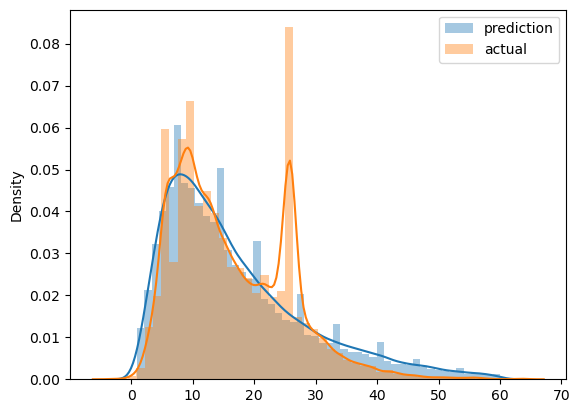

In [16]:
sns.distplot(y_train, label='prediction')
sns.distplot(y_pred, label='actual')

plt.legend()

In [27]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [36]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Manthan")
    mlflow.log_param("train-data","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data","./data/green_tripdata_2021-02.parquet")

    

    alpha = 0.0001
    mlflow.log_param("alpha", alpha)
    ls = Lasso(alpha)
    ls.fit(X_train, y_train)

    y_pred = ls.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    print(rmse)

7.616617761096093
